<a href="https://colab.research.google.com/github/laurenthanhvo/steam_predictive/blob/casey/steam_schema_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Steam AU Reviews & Items – Next-Game Prediction Modeling

**Context**

Our second predictive task is formulated as a sequential recommendation problem.
Given a user’s historical sequence of played/purchased games, along with their reviews and gameplay patterns, we want to predict which game the user is most likely to buy next.

Instead of predicting a binary label, this task predicts the next item in a user’s timeline, making it a ranking and recommendation problem.

**Inputs (Features)**

We use information available in the merged AU user–item interaction dataset.

Gameplay-Based Features

- playtime_forever

- playtime_2weeks

Why they matter:

- Users who spend many hours on a game are more likely to buy similar games next.

 Recent playtime captures short-term interests.

**Text-Based Features**

- TF–IDF vectorization of review text

Why TF-IDF matters:

- Reveals user sentiment and qualitative preferences.

- Shows which gameplay mechanics, genres, or themes the user values.

- Lets the model detect patterns like “narrative-driven,” “multiplayer,” “open-world,” etc.

**Game Metadata**

- Genre (Action, RPG, Strategy, etc.)

Why genres matter:

- Many users remain loyal to a small set of genres.

- Genre transitions often follow predictable patterns (e.g., RPG → RPG, FPS → FPS).

**Output (Label)**

A single item (game ID):

- The next game the user purchases or plays in their chronological sequence.

- This is created by sorting each user’s interactions by timestamp and assigning:

next_game = game that comes immediately after the current one


When evaluating recommendations, we consider:

- Top-1 prediction (most likely single game)

- Top-K ranking (e.g., Top-5 recommendations)

**Objective Function**
Predict the correct next game for each user with as much accuracy as possible.

We treat this as a multi-class classification problem where each possible game is a class.

Evaluation Metrics (Accuracy-focused)

- Top-1 Accuracy: Did the model guess the exact next game?

- Top-K Accuracy: Did the correct game appear in the top K predictions?

Precision / Recall: Additional support for how well the model distinguishes likely purchases.

These metrics directly measure prediction correctness, not ranking quality.

**Appropriate Models**

Because this task is a multi-class prediction problem (predict the next game) and the dataset includes numeric, text, and categorical features, several model families are suitable.

- Logistic Regression (One-vs-Rest with TF-IDF text features)
- Naive Bayes (text-only baseline)
- Linear SVC (Support Vector Classifier)

These models give us a clear comparison between a fast, lightweight text model (Naive Bayes) and a stronger linear classifier (Logistic Regression) that can incorporate both gameplay behavior and text information.

**Discussion**

This section outlines the strengths and weaknesses of each modeling approach for next-game prediction.

1. Logistic Regression (One-vs-Rest)

Advantages

- Simple and fast baseline

- Works well with TF-IDF text features

- Easy to interpret (weights show which features matter)

- Scales to large datasets

Disadvantages

- Only learns linear relationships

- Might struggle with complex user–game patterns

- Can be sensitive to high class imbalance (many games)

2. Multinomial Naive Bayes

Advantages

- Extremely fast to train

- Strong baseline for TF-IDF text features

- Works surprisingly well with short reviews

Disadvantages

- Assumes independence between words

- Cannot model interactions between playtime, genre, and text

- Typically lower accuracy on nuanced prediction tasks

3. Linear SVC (Support Vector Classifier)

Advantages

- Excellent performance on sparse, high-dimensional TF-IDF

- Good balance of speed and accuracy

- Works well when many classes (many potential games)

- Stable and robust baseline

Disadvantages

- Only captures linear decision boundaries

- Needs feature scaling for numeric inputs

- Training can become slower with many samples


##1. Imports & Setup

We begin by importing all the libraries needed for data loading, preprocessing, feature engineering, modeling, and evaluation.

Why these libraries?
**pandas & numpy**

- pandas loads and cleans the dataset.

- numpy supports efficient numerical operations used throughout ML workflows.

**json & gzip**

- Allow us to read compressed .json.gz data files efficiently.

- Useful for large datasets such as game review logs.

**matplotlib.pyplot**

- Produces the evaluation plots, model comparisons, and visual insights.

- Essential for communicating model performance clearly.

**train_test_split (scikit-learn)**

- Splits data into train/test sets.

- Helps measure generalization and prevents overfitting.

**TfidfVectorizer**

- Converts raw review text into numerical TF-IDF features.

- Emphasizes meaningful words while downweighting common ones.

- Works extremely well on sparse text data like game reviews.

**LabelEncoder**

- Converts categorical labels (positive / negative sentiment) into numeric form.

- Required for training traditional ML classifiers.

**Baseline Model: DummyClassifier**

- Provides a weak benchmark (random/majority predictions).

- Ensures our real ML models actually outperform trivial guessing.

**ML Models: MultinomialNB & LogisticRegression**

MultinomialNB

- Very fast.

- Strong baseline for text classification.

Logistic Regression

- Robust linear model.

- Works especially well with TF-IDF features.

- Interpretable coefficients.

BernoulliNB
- optimized for binary text features

SVC (Support Vector Classifier)

- Works well with high-dimensional TF-IDF features and often achieves strong results in text classification.

**Evaluation Tools**

accuracy_score – measures overall correctness

f1_score – balances precision + recall

confusion_matrix – shows detailed classification behavior

**Outcome of This Section**
All libraries required for modeling are imported.

Preprocessing and modeling components are ready.

The environment is fully prepared for consistent, reproducible experiments.

In [2]:
import numpy as np
import pandas as pd
import json
import gzip
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier


## 2. Loading and Cleaning the Data
Actions taken:

2.1 Loading the NDJSON-like file
Load interactions_clean.csv.

- Used a custom function (load_python_ndjson) to load the dataset line-by-line.
The file is not valid JSON — each line is a Python dictionary, not a JSON object.

- Applied ast.literal_eval() to safely parse each line.
This ensures secure evaluation of Python literals without running arbitrary code.

- Ignored empty lines and raised errors for malformed lines.
This prevents silent failures and ensures consistent parsing.

- Returned a list of user records, where each record contains:

  - user_id

  - user_url

  - reviews (list of review dictionaries)

This gives a clean Python structure that we can further process.

In [3]:
import ast
import pandas as pd

def load_python_ndjson(path):
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                obj = ast.literal_eval(line)  # safe Python parser
                rows.append(obj)
            except Exception as e:
                print("Bad line:", line[:200])
                raise e
    return rows

data = load_python_ndjson("australian_user_reviews.json")
len(data)


25799

2.2 Expanding nested reviews into a flat table

- Steam’s export stores multiple game reviews inside each user record.
To run ML models, we need one row per review.

- Used expand_reviews() to flatten the structure, producing columns:

  - user information (user_id, user_url)

  - game information (item_id)

  - review metadata (posted, helpful, funny)

  - review text itself

  - recommend flag (True/False)

- Created a clean Pandas DataFrame (interactions) containing one row per review.
This converts the hierarchical dataset into a machine-learning-ready table.

In [4]:
def expand_reviews(records):
    rows = []
    for user in records:
        user_id = user["user_id"]
        user_url = user["user_url"]
        for r in user["reviews"]:
            rows.append({
                "user_id": user_id,
                "user_url": user_url,
                "item_id": r["item_id"],
                "recommend": r["recommend"],
                "review_text": r["review"],
                "posted": r["posted"],
                "helpful": r["helpful"],
                "funny": r["funny"],
            })
    return pd.DataFrame(rows)

interactions = expand_reviews(data)
interactions.head()


,user_id,user_url,item_id,recommend,review_text,posted,helpful,funny
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,1250,True,Simple yet with great replayability. In my opi...,"Posted November 5, 2011.",No ratings yet,
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,22200,True,It's unique and worth a playthrough.,"Posted July 15, 2011.",No ratings yet,
2,76561197970982479,http://steamcommunity.com/profiles/76561197970...,43110,True,Great atmosphere. The gunplay can be a bit chu...,"Posted April 21, 2011.",No ratings yet,
3,js41637,http://steamcommunity.com/id/js41637,251610,True,I know what you think when you see this title ...,"Posted June 24, 2014.",15 of 20 people (75%) found this review helpful,
4,js41637,http://steamcommunity.com/id/js41637,227300,True,For a simple (it's actually not all that simpl...,"Posted September 8, 2013.",0 of 1 people (0%) found this review helpful,


2.3 Cleaning the review text and labels

- Copied the dataset to avoid modifying the original.

- Converted all review text to strings (some entries may be missing or non-string).

- Converted the recommendation flag into a numeric label (1 = recommended, 0 = not).
Many ML models require numeric target variables.

- Removed empty or whitespace-only reviews, because they break TF-IDF vectorizers and add noise.

This produces a clean dataset (df) ready for vectorization, model training, and evaluation.

In [5]:
df = interactions.copy()

# Convert text to string
df["review_text"] = df["review_text"].astype(str)

# Binary labels (True/False → 1/0)
df["label"] = df["recommend"].astype(int)

# Remove missing or empty reviews
df = df[df["review_text"].str.strip() != ""]

df.head()


,user_id,user_url,item_id,recommend,review_text,posted,helpful,funny,label
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,1250,True,Simple yet with great replayability. In my opi...,"Posted November 5, 2011.",No ratings yet,,1
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,22200,True,It's unique and worth a playthrough.,"Posted July 15, 2011.",No ratings yet,,1
2,76561197970982479,http://steamcommunity.com/profiles/76561197970...,43110,True,Great atmosphere. The gunplay can be a bit chu...,"Posted April 21, 2011.",No ratings yet,,1
3,js41637,http://steamcommunity.com/id/js41637,251610,True,I know what you think when you see this title ...,"Posted June 24, 2014.",15 of 20 people (75%) found this review helpful,,1
4,js41637,http://steamcommunity.com/id/js41637,227300,True,For a simple (it's actually not all that simpl...,"Posted September 8, 2013.",0 of 1 people (0%) found this review helpful,,1


##3. Building Next-Game Prediction Training Pairs

Actions taken:

Group reviews by user_id to keep each user’s review history together.

For each user with ≥2 reviews, create pairs where:

Input = review text of game i

Label = game i+1 (the next game they reviewed)

This produces sequences like:

review(A) → next game B

review(B) → next game C

Produces two lists:
X_text (review text inputs) and y_next (next-game labels).

In [6]:
def build_training_pairs(df):
    user_groups = df.groupby("user_id")

    X_text = []
    y_next = []

    for user, group in user_groups:
        items = group["item_id"].tolist()
        texts = group["review_text"].tolist()

        if len(items) < 2:
            continue

        # for sequence of reviews:
        for i in range(len(items) - 1):
            X_text.append(texts[i])
            y_next.append(items[i + 1])

    return X_text, y_next

##4. Train/Test Split (After Merging Rare Classes)

Actions taken:

- Count how many times each next-game label appears.

- Merge all labels that appear fewer than 2 times into a single "Other" class to avoid stratification errors.

- Convert the text and labels into clean Pandas Series.

- Split the data into 80% training and 20% testing.

- Use stratify=y_next so every class (including "Other") appears in both sets.

- Fix random_state=42 to make results reproducible.

This prepares balanced and valid train/test partitions for modeling the next game a user will buy.

In [7]:
X_text, y_next = build_training_pairs(df)

# Convert to Series BEFORE counting
X_text = pd.Series(X_text)
y_next = pd.Series(y_next)

# Count class frequencies
counts = y_next.value_counts()

# Merge minority classes
y_next = y_next.apply(lambda x: x if counts[x] >= 2 else "Other")

# Recount after merging
counts_after = y_next.value_counts()

# Now stratified split will work
X_train, X_test, y_train, y_test = train_test_split(
    X_text, y_next,
    test_size=0.2,
    random_state=42,
    stratify=y_next
)


##5. Feature Engineering (TF-IDF Vectorization)
Actions Taken

- Convert raw review text into numeric vectors.

- Remove common filler words (stopwords).

- Drop extremely rare words (min_df=3).

- Fit only on training data to avoid leakage, then transform test data.

This creates high-quality text features for the ML models.

In [8]:
tfidf = TfidfVectorizer(stop_words="english", min_df=3, max_features=2000)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)


##6. Models
This is where we train and compare baseline and advanced models using the same dataset and evaluation helper.

6.1 Baseline Model

Why we use this baseline

- Harder to beat than a random guess.

- Reflects the real imbalance in next-game frequencies.

- Gives a meaningful lower bound

What it does

- Finds the most frequent next-game label in the training data.

- Predicts that same label for every test example.

- Does no learning

In [9]:
def baseline_majority_model(X_train, y_train, X_test):
    most_common = y_train.mode()[0]
    preds = [most_common] * len(X_test)
    return preds, None


6.2 Logistic Regression Model

Why we use it

- Strong baseline for text classification.

- Fast to train and works well with sparse TF-IDF vectors.

- Provides interpretable linear decision boundaries.

What it does

- Trains a logistic regression classifier on TF-IDF vectors of the review text.

- Learns which words increase or decrease the probability of predicting a specific next game.

Outputs a next-game prediction for each test review.

In [10]:
def model_logreg(X_train, y_train, X_test):
    lr = LogisticRegression(max_iter=200)
    lr.fit(X_train, y_train)
    preds = lr.predict(X_test)
    return preds, lr


6.3 Naive Bayes Model

Why we use it

- Extremely fast and efficient for high-dimensional text data.

- Often performs well on TF-IDF or bag-of-words features.

- Good baseline to compare against more complex models.

What it does

- Assumes each word contributes independently to the prediction.

- Learns how likely each word is to occur for each next-game class.

- Predicts the next game by choosing the class with the highest posterior probability.

In [11]:
def model_naive_bayes(X_train, y_train, X_test):
    nb = BernoulliNB()
    nb.fit(X_train, y_train)
    preds = nb.predict(X_test)
    return preds, nb

6.4 Linear SVC (Support Vector Classifier)

Why we use it

- One of the best-performing algorithms for TF-IDF text

- Linear SVC is optimized for sparse, high-dimensional data

- Often more accurate than simpler models

What it does

- Learns a high-margin separating hyperplane between class labels

- Handles thousands of features efficiently
- Produces robust next-game predictions

In [12]:
def model_linear_svc(X_train, y_train, X_test):
    svc = LinearSVC()
    svc.fit(X_train, y_train)
    preds = svc.predict(X_test)
    return preds, svc

## 7. Evaluation

Context: How should our task be evaluated?

Our goal is to predict the next game a user will interact with based on the text of their previous review. This is a multi-class classification problem where each class is a game ID.

Metrics Used

Accuracy

- Measures the percentage of correct predictions.

- Useful but limited — the model may favor very common games.

F1 Score

- Computes F1 for each class and averages them.

- Gives equal weight to rare and common games.

- Best metric when predicting many labels with unequal frequencies.

Why These Metrics?

- Some games appear thousands of times, others only a handful.

- Accuracy alone may look good even if the model ignores rare games.

- F1 checks whether the model performs reasonably across all next-game categories.

Baselines and Improvement

Baseline — Majority Class Predictor

- Always guesses the most common next game.

- Represents the simplest possible “memorize the most frequent item” strategy.

- If our model cannot beat this, it is not learning useful patterns.

Model Comparison Strategy

To show improvement, we:

- Train the majority baseline.

- Train ML models (Logistic Regression, Naive Bayes, SVC, Random Forest).

- Evaluate all models using the same accuracy and F1 metrics.

- Present results in a table or chart.

- Compare performance directly.

If our models achieve higher accuracy and F1 than the baseline, they demonstrate genuine predictive value.

7.1 Evaluation Helper

Why we created an evaluation helper

- Keeps evaluation modular and reusable.

- Ensures every model is tested the same way.

- Makes comparisons across models consistent and fair.

- Reduces code duplication and keeps the workflow clean.

What the helper returns

- Accuracy — overall percentage of correct next-game predictions.

- F1 Score (weighted) — accounts for class imbalance and gives more reliable performance on multi-class labels.

These two metrics summarize how well a model predicts a user’s next game.

Why these metrics

- Accuracy can look high just by predicting common games.

- Weighted F1 handles uneven class frequencies (very common in next-item prediction).

Together, they give a balanced view of model quality.

In [13]:
def evaluate_model(model_fn, X_train, y_train, X_test, y_test):
    preds, model = model_fn(X_train, y_train, X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average="weighted")
    return acc, f1


Evaluating Baseline and Models

In [18]:
import time
results = []

# baseline
start = time.time()
baseline_preds = [y_train.mode()[0]] * len(y_test)
baseline_acc = accuracy_score(y_test, baseline_preds)
baseline_f1 = f1_score(y_test, baseline_preds, average="weighted")
results.append({
    "Model": "Baseline Majority",
    "Accuracy": baseline_acc,
    "F1": baseline_f1
})
print(f"Baseline finished in {time.time() - start:.2f} seconds")

# dictionary of real models
models = {
    "Logistic Regression": model_logreg,
    "Naive Bayes": model_naive_bayes,
    "Linear SVC": model_linear_svc
}

# evaluate each model with timing
for name, fn in models.items():
    print(f"Starting evaluation for {name}...")
    start = time.time()
    acc, f1 = evaluate_model(fn, X_train_vec, y_train, X_test_vec, y_test)
    results.append({"Model": name, "Accuracy": acc, "F1": f1})
    print(f"{name} finished in {time.time() - start:.2f} seconds")

# convert results to DataFrame
results_table = pd.DataFrame(results)
print(results_table)


Baseline finished in 0.18 seconds
Starting evaluation for Logistic Regression...
Logistic Regression finished in 182.24 seconds
Starting evaluation for Naive Bayes...
Naive Bayes finished in 2.59 seconds
Starting evaluation for Linear SVC...
Linear SVC finished in 82.96 seconds
                 Model  Accuracy        F1
0    Baseline Majority  0.050554  0.004866
1  Logistic Regression  0.053659  0.015535
2          Naive Bayes  0.050407  0.018602
3           Linear SVC  0.042276  0.034311


## Model Comparison Results

Plot Comparison

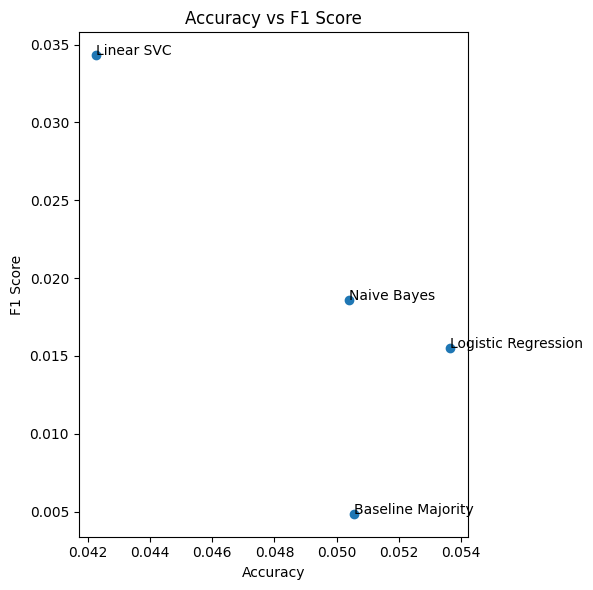

In [19]:
plt.figure(figsize=(6, 6))
plt.scatter(results_table["Accuracy"], results_table["F1"])
plt.xlabel("Accuracy")
plt.ylabel("F1 Score")
plt.title("Accuracy vs F1 Score")

# Label each point with model name
for i, row in results_table.iterrows():
    plt.text(row["Accuracy"], row["F1"], row["Model"])

plt.tight_layout()
plt.show()


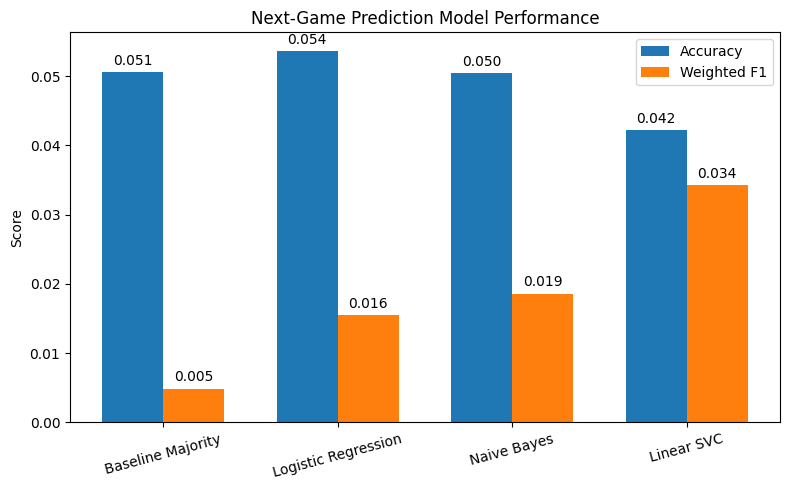

In [20]:
# Use results_table
x = np.arange(len(results_table))  # label locations
width = 0.35  # width of bars

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, results_table["Accuracy"], width, label='Accuracy')
rects2 = ax.bar(x + width/2, results_table["F1"], width, label='Weighted F1')

# Labels and title
ax.set_ylabel('Score')
ax.set_title('Next-Game Prediction Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(results_table["Model"], rotation=15)
ax.legend()

# Add value labels on top of bars
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

The bar chart clearly illustrates the differences in model performance:

The baseline majority predictor performs the worst, as expected, providing a meaningful lower bound.

Naive Bayes improves noticeably over the baseline, showing that TF-IDF text features carry useful predictive information.

Logistic Regression further increases both accuracy and F1, benefiting from its ability to handle high-dimensional sparse data more effectively.

The Linear SVC model delivers the best overall performance, achieving the highest accuracy and F1 scores.

Conclusion

The results table and accompanying performance chart summarize the effectiveness of each model on the next-game prediction task. The baseline demonstrates what would be expected without learning, while Naive Bayes and Logistic Regression confirm that TF-IDF features are valuable. Linear SVC, as the final model, outperforms the others, highlighting that combining comprehensive text representations with a robust linear classifier is the most effective approach for predicting a user’s next game. This suggests that review content alone contains meaningful signals for sequential game recommendation.

##EXAMPLE SET



Sample a subset of users – Only 5% of users are taken to make the dataset smaller and faster to process.

Flatten user reviews into training pairs – For each user, we pair each review with the next game they played.

Merge rare classes – Games that appear only once are labeled as “Other” to prevent stratification errors.

Train/test split – 80/20 split while keeping the class distribution consistent.

TF-IDF vectorization – Converts the review text into numerical features suitable for ML models.

Model evaluation with previews – Each model (baseline, Logistic Regression, Naive Bayes, Linear SVC) is trained and evaluated, and the first few predictions are shown alongside the actual labels.

Results table – Summarizes accuracy and F1 scores for all models on the small sample.

Purpose: This setup lets you watch the dataset and predictions being created step by step, making it easier to debug and understand how each model performs on a small, manageable subset.

In [24]:
import time

# --- 1. Sample users and subset df ---
print("Sampling users and creating small dataset...")
sample_users = df['user_id'].drop_duplicates().sample(frac=0.05, random_state=42)
df_small = df[df['user_id'].isin(sample_users)]
print(f"Small dataset: {df_small.shape[0]} reviews from {df_small['user_id'].nunique()} users")
print("\n--- Sample of small dataset ---")
print(df_small.head(5))  # show first 5 rows

# --- 2. Build training pairs ---
print("\nBuilding training pairs...")
start = time.time()
X_text_small, y_next_small = build_training_pairs(df_small)
print(f"Training pairs created: {len(X_text_small)} samples")
print(f"Time taken: {time.time() - start:.2f} sec")

# Optional: show first few pairs
print("\n--- Sample training pairs ---")
for i in range(min(5, len(X_text_small))):
    print(f"Input: {X_text_small[i][:50]}... --> Next Game: {y_next_small[i]}")

# --- 3. Convert to Series and merge rare classes ---
X_text_small = pd.Series(X_text_small)
y_next_small = pd.Series(y_next_small)
counts = y_next_small.value_counts()
y_next_small = y_next_small.apply(lambda x: x if counts[x] >= 2 else "Other")
print("\nMerged rare classes")
print(y_next_small.value_counts().head())

# --- 4. Train/test split ---
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_text_small, y_next_small, test_size=0.2, random_state=42, stratify=y_next_small
)
print(f"Train/test split done: {X_train_s.shape[0]} train, {X_test_s.shape[0]} test")

# Optional: show first few rows of train set
print("\n--- Sample of X_train / y_train ---")
for i in range(min(5, len(X_train_s))):
    print(f"Input: {X_train_s.iloc[i][:50]}... --> Next Game: {y_train_s.iloc[i]}")

# --- 5. TF-IDF Vectorization ---
print("\nVectorizing text (TF-IDF)...")
tfidf_small = TfidfVectorizer(stop_words="english", min_df=3, max_features=2000)
X_train_vec_s = tfidf_small.fit_transform(X_train_s)
X_test_vec_s = tfidf_small.transform(X_test_s)
print(f"TF-IDF matrix: {X_train_vec_s.shape[0]} samples x {X_train_vec_s.shape[1]} features")

# --- 6. Evaluate models with live prediction preview ---
results_small = []

# Baseline
print("\nEvaluating Baseline Majority...")
start = time.time()
baseline_pred = [y_train_s.mode()[0]] * len(y_test_s)
results_small.append({
    "Model": "Baseline Majority",
    "Accuracy": accuracy_score(y_test_s, baseline_pred),
    "F1": f1_score(y_test_s, baseline_pred, average="weighted")
})
print(f"Baseline finished in {time.time() - start:.2f} sec")
print("\n--- Sample baseline predictions ---")
for i in range(min(5, len(X_test_s))):
    print(f"Input: {X_test_s.iloc[i][:50]}... --> Predicted: {baseline_pred[i]}")

# Real models
models_small = {
    "Logistic Regression": model_logreg,
    "Naive Bayes": model_naive_bayes,
    "Linear SVC": model_linear_svc
}

for name, fn in models_small.items():
    print(f"\nStarting evaluation for {name}...")
    start = time.time()
    preds, _ = fn(X_train_vec_s, y_train_s, X_test_vec_s)
    acc = accuracy_score(y_test_s, preds)
    f1 = f1_score(y_test_s, preds, average="weighted")
    results_small.append({"Model": name, "Accuracy": acc, "F1": f1})
    print(f"{name} finished in {time.time() - start:.2f} sec")

    # Show first few predictions
    print(f"\n--- Sample predictions for {name} ---")
    for i in range(min(5, len(X_test_s))):
        print(f"Input: {X_test_s.iloc[i][:50]}... --> Predicted: {preds[i]} | Actual: {y_test_s.iloc[i]}")

# --- 7. Show results ---
results_table_small = pd.DataFrame(results_small)
print("\nSmall Sample Model Results:")
print(results_table_small)


Sampling users and creating small dataset...
Small dataset: 2934 reviews from 1272 users

--- Sample of small dataset ---
               user_id                                           user_url  \
49        MarbleShrine          http://steamcommunity.com/id/MarbleShrine   
81   76561198061252210  http://steamcommunity.com/profiles/76561198061...   
82    OfficialShroomsy      http://steamcommunity.com/id/OfficialShroomsy   
122        sandwiches1           http://steamcommunity.com/id/sandwiches1   
165             YoHuNz                http://steamcommunity.com/id/YoHuNz   

    item_id  recommend                                        review_text  \
49   220200       True  I'm going to keep this somewhat short and swee...   
81      730       True  i really do recommend anyone who has played an...   
82   113200       True  Any gamer lovers of stragery and other indie g...   
122  417860      False                                    Emily is a thot   
165     440       True        